In [ ]:
# imports
import pandas as pd
import os

from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout, Input, Activation, Add, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import random 
import numpy as np 

from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers

import datetime
from datetime import timedelta

import polars as pl

import seaborn as sns

import data_preprocessing
from data_integration import combine_data, read_data

In [ ]:
"""
    Calls the "read_data()" function from file "data_integration.py"
    Calls the "combine_data()" function from file "data_integration.py"
    Parameter:
    - 1: combines only glucose data
    - 2: combines glucose and dempgraphics
    - 3: combines glucose and heartrate
    Output: This function returns the intrgrated dataset included the restricted databases if downloaded and added to folder "datasets for T1D"
 """
# reads all datasets, if they are stored in the required folder DiaData/datasets for T1D/...
restricted_list = read_data(read_all = True)

In [ ]:
subdatabaseI = combine_data(2, restricted_list)  

## outlier detection

In [ ]:
# applies outlier removal
data_cleaned = data_preprocessing.remove_outliers(subdatabaseI, value = "GlucoseCGM", modus = "glucose", subject = "PtID")

In [5]:
# sorts by lower bound of the range since the plots are not ordered by the age range
def get_lower_bound(range_str):
    # extracts the first number of the age range, converts it to an integer, and returns the value 
    try:
        return int(range_str.split("-")[0])
    except: 
        return int(range_str.split("+")[0])

/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_36306/2349515039.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_subI2_filtered["lower_bound"] = combined_subI2_filtered["AgeGroup"].apply(get_lower_bound)


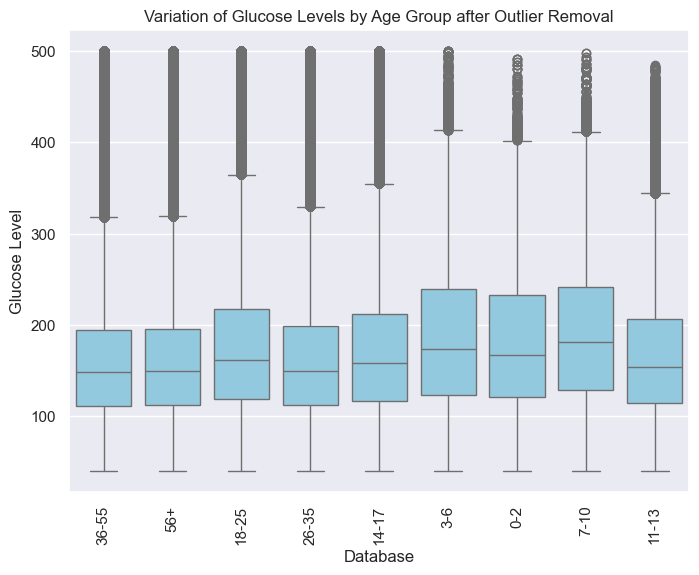

In [8]:
# first, the nan values in the "GlucoseCGM" column are removed
combined_subI2_filtered = data_cleaned.dropna(subset=["GlucoseCGM"])

# then, the dataframe is ordered based on the age group
combined_subI2_filtered["lower_bound"] = combined_subI2_filtered["AgeGroup"].apply(get_lower_bound)
combined_subI2_filtered = combined_subI2_filtered.sort_values("lower_bound")

# creates correct order list
age_order = combined_subI2_filtered[["AgeGroup", "lower_bound"]].drop_duplicates().sort_values("lower_bound")["AgeGroup"].tolist()

# makes "AgeGroup" a categorical with correct order to enable plotting 
combined_subI2_filtered["AgeGroup"] = pd.Categorical(combined_subI2_filtered["AgeGroup"], categories=age_order, ordered=True)

# Create boxplot
plt.figure(figsize=(8, 6))
sns.set_theme(style="darkgrid")
sns.boxplot(x='AgeGroup', y='GlucoseCGM', data=data_cleaned, showfliers=True, color='skyblue')  
plt.xticks(rotation=90)
# Add title and labels
plt.title("Variation of Glucose Levels by Age Group after Outlier Removal")
plt.suptitle("")  
plt.xlabel("Database")
plt.ylabel("Glucose Level")
plt.show()

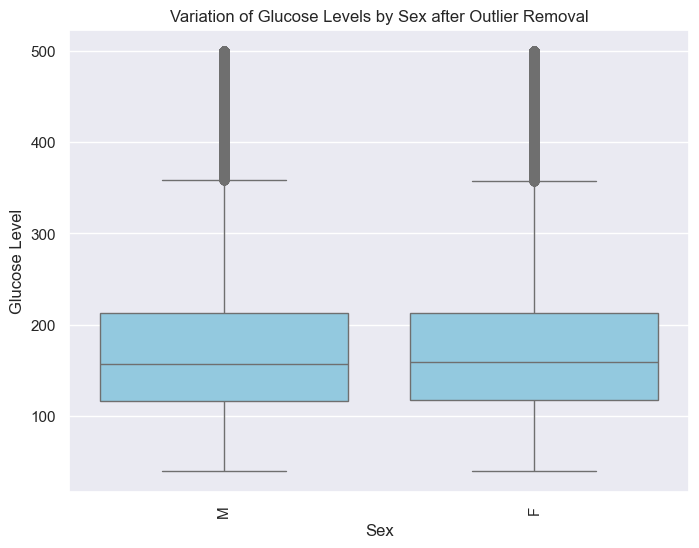

In [ ]:
# creates boxplot
plt.figure(figsize=(8, 6))
sns.set_theme(style="darkgrid")
sns.boxplot(x='Sex', y='GlucoseCGM', data=data_cleaned, showfliers=True, color='skyblue')  
plt.xticks(rotation=90)
# adds title and labels
plt.title("Variation of Glucose Levels by Sex after Outlier Removal")
plt.suptitle("")  
plt.xlabel("Sex")
plt.ylabel("Glucose Level")
plt.show()

## Missing values imputation

In [ ]:
# linear interpolation is used for gaps which are less than 30 minute (6 consecuitve datapoints)
df_interpolated = data_cleaned.copy()
df_interpolated['GlucoseCGM'] = df_interpolated.groupby('PtID')['GlucoseCGM'].transform(
    lambda x: data_preprocessing.gap_limited_interpolation(x, limit=6)
)

# stineman interpolation for values between 30 adn 120 minutes
df_interpolated_stine = df_interpolated.groupby("PtID", group_keys=False).apply(lambda x: data_preprocessing.interpolate_stineman_group(x, timestamp = "ts", value = "GlucoseCGM", llimit=6, ulimit=24))
df_interpolated_stine = df_interpolated_stine.sort_index()

In [ ]:
# as a comparison, a copy of the cleaned dataset before imputation is made
only_interpolated = data_cleaned.copy()

# missing values of this copy are imputed with linear interpolation for all gaps lengths
only_interpolated['GlucoseCGM'] = only_interpolated.groupby('PtID')['GlucoseCGM'].transform(lambda group: group.interpolate(method='linear'))

/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_10884/383817101.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_10884/383817101.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels())


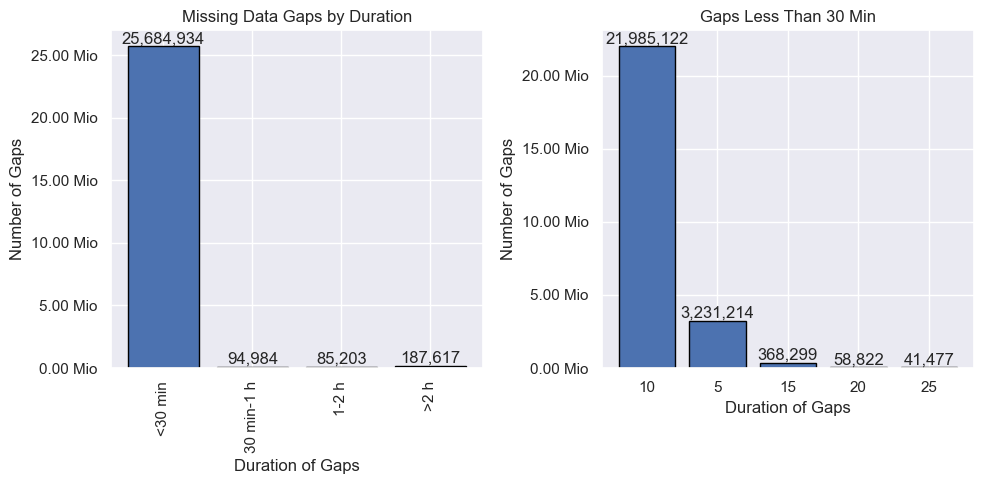

In [ ]:
from matplotlib.ticker import FuncFormatter
# plots missing values to explore the data quality

# function to show both value and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        val_mio = round(val / 1_000_000, 1)
        return f"{val} ({pct:.1f}%)"
    return my_autopct

# the dataframe is copied
df_glc_missing = subdatabaseI.copy()
# first, missing blocks are identified 
df_glc_missing["missing"] = df_glc_missing["GlucoseCGM"].isna()

# uses groupby with cumsum to find continuous blocks
df_glc_missing["gap_id"] = (df_glc_missing["missing"] != df_glc_missing["missing"].shift()).cumsum()
# groups by the identified gaps
na_groups = df_glc_missing[df_glc_missing["missing"]].groupby("gap_id").size().reset_index(name="missing_count")
# one row of missing data equals 5 minutes, so the length of gap is multiplied by 5
na_groups["missing_count_time"] = na_groups["missing_count"] * 5

# categorizes durations based on specified bins and labels
bins = [0,30,60,120,na_groups["missing_count_time"].max()]
labels = [
    "<30 min",
    "30 min-1 h",
    "1-2 h",
    ">2 h"
]
# converts durations to timedelta seconds for binning
duration_bins = pd.cut(na_groups["missing_count_time"], bins=bins, labels=labels, right=False)

# counts number of gaps per duration range
gap_counts = duration_bins.value_counts().sort_index()

# creates the bin groups
na_groups["MissingGroup"] = pd.cut(na_groups["missing_count_time"], bins=bins, labels=labels, right=False)
# filters to only less than 30 minute gaps
count_30_missing = na_groups[na_groups["MissingGroup"] ==  "<30 min"]["missing_count_time"].value_counts()

# plots the missing values count per created group and for the second group of less than 30 minutes in 5 minute intervals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plots the barchart of all missing value groups
ax1.bar(gap_counts.index.astype(str), gap_counts.values, edgecolor="black")
ax1.set_title("Missing Data Gaps by Duration")
ax1.set_xlabel("Duration of Gaps")
ax1.set_ylabel("Number of Gaps")

# formatter function
def millions(x, pos):
    return f"{x*1e-6:.2f} Mio"

# applyies formatter to axis
ax1.yaxis.set_major_formatter(FuncFormatter(millions))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# plots the numbers on the bar
'''for bar in ax1.patches:
    height = bar.get_height()
    # Converts to millions, cleans up trailing zeros
    label = f"{height / 1e6:.2f} Mio".rstrip("0").rstrip(".")  
    ax1.text(bar.get_x() + bar.get_width() / 2, height, label,
             ha="center", va="bottom")'''
    
for bar in ax1.patches:
    height = bar.get_height()
    label = f"{int(height):,}"  # adds comma separators for readability
    ax1.text(
        bar.get_x() + bar.get_width() / 2,  # center of the bar
        height,                             # top of the bar
        label,                              # text to display
        ha="center", va="bottom"
    )

# plots the missing values distribution less than 30 minutes as a bar chart
ax2.bar(count_30_missing.index.astype(str), count_30_missing.values, width=0.8, edgecolor="black")
ax2.set_title("Gaps Less Than 30 Min")
ax2.set_xlabel("Duration of Gaps")
ax2.set_ylabel("Number of Gaps")

'''# adda text labels on top of each bar
for bar in ax2.patches:
    height = bar.get_height()
    # Converts to millions, cleans up trailing zeros
    label = f"{height / 1e6:.2f} Mio".rstrip("0").rstrip(".")  
    ax2.text(bar.get_x() + bar.get_width() / 2, height, label,
             ha="center", va="bottom")'''
for bar in ax2.patches:
    height = bar.get_height()
    label = f"{int(height):,}"  # adds comma separators for readability
    ax2.text(
        bar.get_x() + bar.get_width() / 2,  # center of the bar
        height,                             # top of the bar
        label,                              # text to display
        ha="center", va="bottom"
    )

# applies formatter to axis 
ax2.yaxis.set_major_formatter(FuncFormatter(millions))
ax2.set_xticklabels(ax2.get_xticklabels())

# layout
plt.tight_layout()
plt.show()

/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_17817/1072839694.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_17817/1072839694.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels())


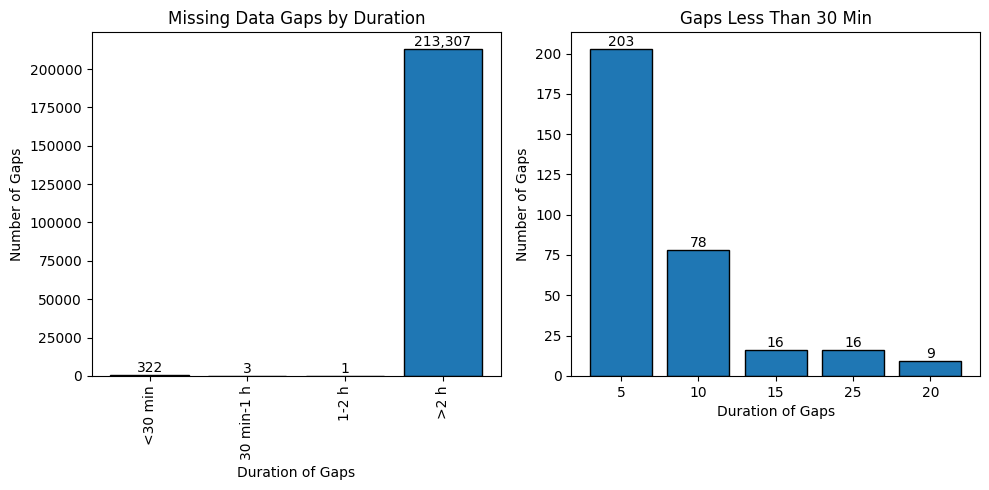

In [32]:
from matplotlib.ticker import FuncFormatter
# plots missing values to explore the data quality

# function to show both value and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        val_mio = round(val / 1_000_000, 1)
        return f"{val} ({pct:.1f}%)"
    return my_autopct

# the dataframe is copied
df_glc_missing = df_interpolated_stine.copy()
# first, missing blocks are identified 
df_glc_missing["missing"] = df_glc_missing["GlucoseCGM"].isna()

# uses groupby with cumsum to find continuous blocks
df_glc_missing["gap_id"] = (df_glc_missing["missing"] != df_glc_missing["missing"].shift()).cumsum()
# groups by the identified gaps
na_groups = df_glc_missing[df_glc_missing["missing"]].groupby("gap_id").size().reset_index(name="missing_count")
# one row of missing data equals 5 minutes, so the length of gap is multiplied by 5
na_groups["missing_count_time"] = na_groups["missing_count"] * 5

# categorizes durations based on specified bins and labels
bins = [0,30,60,120,na_groups["missing_count_time"].max()]
labels = [
    "<30 min",
    "30 min-1 h",
    "1-2 h",
    ">2 h"
]
# converts durations to timedelta seconds for binning
duration_bins = pd.cut(na_groups["missing_count_time"], bins=bins, labels=labels, right=False)

# counts number of gaps per duration range
gap_counts = duration_bins.value_counts().sort_index()

# creates the bin groups
na_groups["MissingGroup"] = pd.cut(na_groups["missing_count_time"], bins=bins, labels=labels, right=False)
# filters to only less than 30 minute gaps
count_30_missing = na_groups[na_groups["MissingGroup"] ==  "<30 min"]["missing_count_time"].value_counts()

# plots the missing values count per created group and for the second group of less than 30 minutes in 5 minute intervals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plots the barchart of all missing value groups
ax1.bar(gap_counts.index.astype(str), gap_counts.values, edgecolor="black")
ax1.set_title("Missing Data Gaps by Duration")
ax1.set_xlabel("Duration of Gaps")
ax1.set_ylabel("Number of Gaps")

# formatter function
def millions(x, pos):
    return f"{x*1e-6:.2f} Mio"

# applyies formatter to axis
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# plots the numbers on the bar
'''for bar in ax1.patches:
    height = bar.get_height()
    # Converts to millions, cleans up trailing zeros
    label = f"{height / 1e6:.2f} Mio".rstrip("0").rstrip(".")  
    ax1.text(bar.get_x() + bar.get_width() / 2, height, label,
             ha="center", va="bottom")'''
    
for bar in ax1.patches:
    height = bar.get_height()
    label = f"{int(height):,}"  # adds comma separators for readability
    ax1.text(
        bar.get_x() + bar.get_width() / 2,  # center of the bar
        height,                             # top of the bar
        label,                              # text to display
        ha="center", va="bottom"
    )

# plots the missing values distribution less than 30 minutes as a bar chart
ax2.bar(count_30_missing.index.astype(str), count_30_missing.values, width=0.8, edgecolor="black")
ax2.set_title("Gaps Less Than 30 Min")
ax2.set_xlabel("Duration of Gaps")
ax2.set_ylabel("Number of Gaps")

'''# adda text labels on top of each bar
for bar in ax2.patches:
    height = bar.get_height()
    # Converts to millions, cleans up trailing zeros
    label = f"{height / 1e6:.2f} Mio".rstrip("0").rstrip(".")  
    ax2.text(bar.get_x() + bar.get_width() / 2, height, label,
             ha="center", va="bottom")'''
for bar in ax2.patches:
    height = bar.get_height()
    label = f"{int(height):,}"  # adds comma separators for readability
    ax2.text(
        bar.get_x() + bar.get_width() / 2,  # center of the bar
        height,                             # top of the bar
        label,                              # text to display
        ha="center", va="bottom"
    )

# applies formatter to axis 
ax2.set_xticklabels(ax2.get_xticklabels())

# layout
plt.tight_layout()
plt.show()